# Level 1: Local Frog Discovery Tool benchmark notebook

## Challenge Level 1 Overview


Welcome to the 2022 EY Data Science Challenge! This is the first challenge aimed at beginner/intermediate participants that have little to no experience in data science and programming. For more experienced participants, we recommend undertaking challenge level 2 outlined [here](Model_Level_2.ipynb). If you choose to undertake the first level of the challenge, you will be developing a species distribution model (SDM) for one Australian frog species using only variables from the TerraClimate dataset. A species distribution model is a specific type of machine learning model that aims to predict the distribution of a biological species across geographic space and time. Such models have become increasingly important in conservation efforts globally to better understand and map the habitats of species of interest, particularly threatened or endangered species. 

The frog species identified for this challenge is Litoria fallax, the eastern dwarf tree frog pictured below. In addition to assisting our understanding of this specific frog species, a successful frog SDM will have broader implications in quantifying biodiversity. This is because frogs are incredibly sensitive to environmental changes, so any changes in their species distribution may indicate an underlying change to biodiversity in the area. 

<center>
<img src="pictures/Litoria_fallax.jpg" width="500" height="340">
</center>

<br>

**Challenge aim:** to develop a species distribution model for litoria fallax across Australia using weather data from the TerraClimate dataset.

| Challenge | Locations                     | Spatial Res        | Species          | Satellite Data                                                |
|-----------|-------------------------------|--------------------|------------------|---------------------------------------------------------------|
|***1***    | Australia                     | Coarse (4km)  | 1 species  | TerraClimate                                                  |
|2     | Australia, Costa Rica,<br>South Africa | Fine (10m)   | 15 species     | TerraClimate, Sentinel-2,<br>Land cover, water extent, elevation |

## Load in dependencies

In [2]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt

# Data science
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

# Geospatial
import contextily as cx
import xarray as xr
import zarr # Not referenced, but required for xarray

# Import Planetary Computer tools
import fsspec
import pystac

# Other
import os
import zipfile
from itertools import cycle

# Path to data folder with provided material
data_path = '/home/frog/notebooks/'

## Response Variable
Before we can build our model, we need to load in the frog occurrences data and generate our response variable. To do this, we first need to unzip the training data and store it on our machine. Then we can write a function that abstracts the loading process, with the option of providing a bounding box to only take those occurrences within a region of interest.


In [3]:
if not os.path.exists(data_path+'training_data/'):
    os.mkdir(data_path+'training_data/')
    with zipfile.ZipFile(data_path+'GBIF_training_data.zip', 'r') as zip_ref:
        zip_ref.extractall(data_path+'training_data/')
        
def filter_bbox(frogs, bbox):
    frogs = frogs[lambda x: 
        (x.decimalLongitude >= bbox[0]) &
        (x.decimalLatitude >= bbox[1]) &
        (x.decimalLongitude <= bbox[2]) &
        (x.decimalLatitude <= bbox[3])
    ]
    return frogs

def get_frogs(file, year_range=None, bbox=None):
    """Returns the dataframe of all frog occurrences for the bounding box specified."""
    columns = [
        'gbifID','eventDate','country','continent','stateProvince',
        'decimalLatitude','decimalLongitude','species'
    ]
    country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }
    continent_names = {
        'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
        'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
        'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
        'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
    }
    frogs = (
        pd.read_csv(data_path+'training_data/occurrence.txt', sep='\t', parse_dates=['eventDate'])
        .assign(
            country =  lambda x: x.countryCode.map(country_names),
            continent =  lambda x: x.countryCode.map(continent_names),
            species = lambda x: x.species.str.title()
        )
        [columns]
    )
    if year_range is not None:
        frogs = frogs[lambda x: 
            (x.eventDate.dt.year >= year_range[0]) & 
            (x.eventDate.dt.year <= year_range[1])
        ]
    if bbox is not None:
        frogs = filter_bbox(frogs, bbox)
    return frogs

### Sub-sampling

We will constrain our search to frogs in the Greater Sydney area found between the start of 1970 to the end of 2020. This gives a varied landscape of bushland, plains, rivers, and urban areas. This is done by providing `year_range` and `bbox` parameters to the get_frogs function we defined above. The coordinates are now that of the NSW area. Afterwards we will focus on a smaller area such that we can study the coast where litoria fallax seem to be concentrated. We wanted to take more years inside the model to check if it gets better. More data availability with focus on a specific area where the phenomena occurs should improve the model.

In [4]:
# Define the bounding box for Greater Sydney, NSW
region_name = 'Greater Sydney, NSW'
min_lon, min_lat = (142.743949, -37.438445)  # Lower-left corner defined with code below
max_lon, max_lat = (153.63, -28.165612)  # Upper-right corner defined with code below
bbox = (min_lon, min_lat, max_lon, max_lat)

# Load in data
all_frog_data = get_frogs(data_path+'/training_data/occurrence.txt', year_range=(1970, 2020), bbox=bbox)
all_frog_data


,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species
0,2574007008,2020-01-23 01:38:00,Australia,Australia,New South Wales,-32.719457,152.159267,Litoria Fallax
7,1944370584,2018-04-18 19:05:00,Australia,Australia,New South Wales,-33.693144,151.320884,Litoria Fallax
17,2423011701,2019-08-28 09:24:00,Australia,Australia,New South Wales,-33.925746,151.164082,Litoria Fallax
21,2236299662,2018-02-13 23:02:00,Australia,Australia,New South Wales,-31.732415,152.088515,Litoria Fallax
23,2563750401,2017-10-25 21:07:00,Australia,Australia,New South Wales,-32.968624,151.644194,Litoria Fallax
...,...,...,...,...,...,...,...,...
193655,476602320,1970-04-04 00:00:00,Australia,Australia,New South Wales,-33.770000,151.250000,Crinia Signifera
193656,476614185,1970-10-25 00:00:00,Australia,Australia,New South Wales,-34.040001,150.860001,Litoria Fallax
193662,476614295,1970-10-25 00:00:00,Australia,Australia,New South Wales,-34.040001,150.690002,Litoria Fallax
193735,1653525892,2015-09-15 00:00:00,Australia,Australia,New South Wales,-33.767500,151.117917,Crinia Signifera


### Addressing bias

Below we define some functions to assist in plotting the frog data. This will assist us in identifying two main areas of bias. We then use these functions to plot the frog species distributions of each country. A more detailed exploration of the training dataset for this challenge can be found in the [dataset summary notebook](supplementary_notebooks/dataset_summary.ipynb).

In [5]:
def plot_species(fig, ax, frog_data, region_name, cmap_params={'alpha':0.5}, scatter_params={'alpha':0.5}):
    # Bar chart
    bar_data = frog_data.species.value_counts()
    barchart = ax[1].bar(bar_data.index.str.replace(' ', '\n'), bar_data)

    # Colour cycle to ensure colors match in both plots
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        species_name = bar_data.index[i]
        if len(species_name) > 19:
            display_name = species_name.replace(' ', '\n')
        else:
            display_name = species_name
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{display_name}\nCount: {bar_data[i]}")
        filt = frog_data.species == species_name
        # Scatter plot
        ax[0].scatter(
            frog_data[filt].decimalLongitude, 
            frog_data[filt].decimalLatitude, 
            marker='.', 
            color=color['color'],
            **scatter_params
        )

    # Add other features
    ax[0].set_title(f"Frog occurrences for {region_name}")
    # ax[0].set_xticklabels([])
    # ax[0].set_yticklabels([])
    ax[1].set_title(f"Frog species distribution in {region_name}")
    cx.add_basemap(ax[0], crs={'init':'epsg:4326'}, **cmap_params) # Add basemap
    ax[1].set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax[1].legend()
    
    
def plot_barchart(bar_data, ax, bar_params={}, fold_text=True):
    barchart = ax.bar(bar_data.index, bar_data, **bar_params)
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        var_name = bar_data.index[i]
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{var_name}\nCount: {bar_data[i]}")
    ax.set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax.legend()

Below, we can visualise the frog species distribution of the area. Here, only two of the five Australian species are present: crinia signifera, the common eastern froglet, and litoria fallax, the eastern dwarf tree frog. It is i clear that litoria fallax are more concentrated on the coastal area

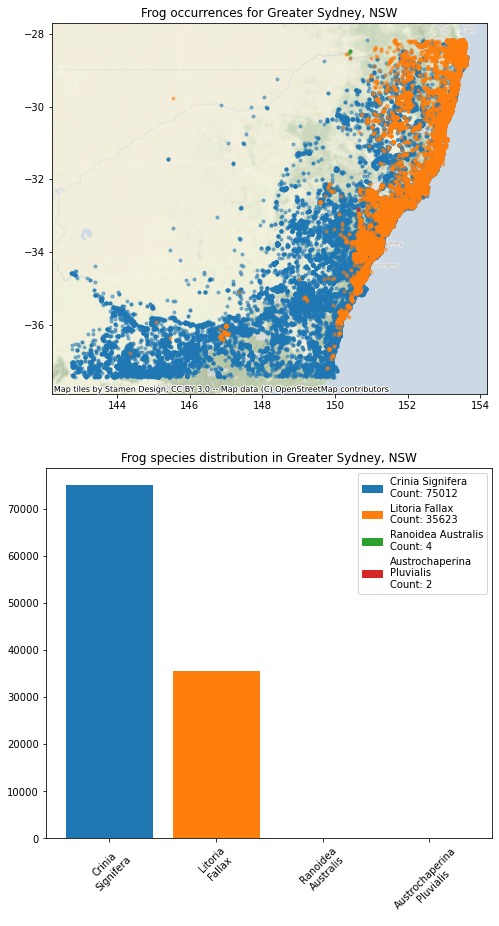

In [6]:
region_name = 'Greater Sydney, NSW'
fig, ax = plt.subplots(2, 1, figsize=(8, 15))
plot_species(fig, ax, all_frog_data, region_name)

#### Sampling bias

The plot above shows how frog occurrences are heavily biased around urban areas, where people are more likely to come across them. They also cluster tightly around towns, parks, bush trails etc. This is one issue that would be worth addressing to maximise success in this challenge.

One method of addressing the sampling bias inherent in the database is to use the occurrence points of other species as absence points for the target species. This is called pseudo-absence and is a common technique in species distribution modelling. This way, if a different species of frog has been sighted in a specific location, we can be more certain that the species we are trying to predict is not at that same location. Alternatively, if we just picked a random point where there are no frog occurrences, we cannot be certain that frogs are not in that location. It might just be that there are no walking tracks near that location, and therefore the frogs would not show up in our database.

The idea is to restrict the area to the coastal one, in fact the litoria fallax species seems to be more present on the coast rather than on land. So the minimum longitude should be at 149 in order to cut the cluster of other frogs which bias our sample. For this I modifiy the above code hereunder and I will stick to the chose of the authors to use an occurence status with the pseudo-absence method.

For this notebook, we will use the other species, crinia signifera - the common eastern froglet, as examples of litoria fallax's absence. We will alter our response variable to be `occurenceStatus` which will take the value of 1 if the occurrence species is litoria fallax, and 0 if the species is not litoria fallax (i.e. is crinia signifera).

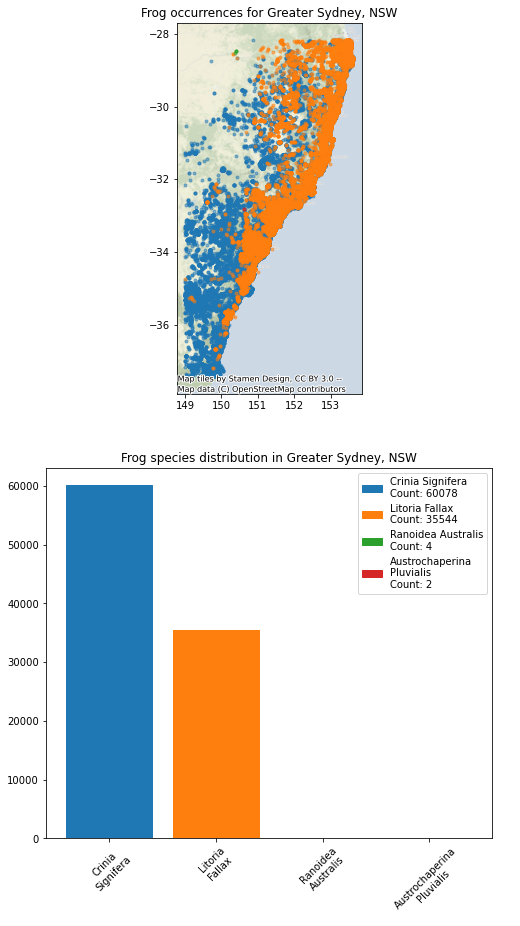

In [7]:
region_name = 'Greater Sydney, NSW'
min_lon, min_lat = (149, -37.438445)  # Lower-left corner defined with code below
max_lon, max_lat = (153.63, -28.165612)  # Upper-right corner defined with code below
bbox = (min_lon, min_lat, max_lon, max_lat)

# Load in data
all_frog_data = get_frogs(data_path+'/training_data/occurrence.txt', year_range=(1970, 2020), bbox=bbox)
all_frog_data

#Plot
fig, ax = plt.subplots(2, 1, figsize=(8, 15))
plot_species(fig, ax, all_frog_data, region_name)

In [8]:
target_species = 'Litoria Fallax'

all_frog_data = (
    all_frog_data
    # Assign the occurrenceStatus to 1 for the target species and 0 for all other species.
    # as well as a key for joining (later)
    .assign(
        occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0)
    )
)
all_frog_data

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus
0,2574007008,2020-01-23 01:38:00,Australia,Australia,New South Wales,-32.719457,152.159267,Litoria Fallax,1
7,1944370584,2018-04-18 19:05:00,Australia,Australia,New South Wales,-33.693144,151.320884,Litoria Fallax,1
17,2423011701,2019-08-28 09:24:00,Australia,Australia,New South Wales,-33.925746,151.164082,Litoria Fallax,1
21,2236299662,2018-02-13 23:02:00,Australia,Australia,New South Wales,-31.732415,152.088515,Litoria Fallax,1
23,2563750401,2017-10-25 21:07:00,Australia,Australia,New South Wales,-32.968624,151.644194,Litoria Fallax,1
...,...,...,...,...,...,...,...,...,...
193655,476602320,1970-04-04 00:00:00,Australia,Australia,New South Wales,-33.770000,151.250000,Crinia Signifera,0
193656,476614185,1970-10-25 00:00:00,Australia,Australia,New South Wales,-34.040001,150.860001,Litoria Fallax,1
193662,476614295,1970-10-25 00:00:00,Australia,Australia,New South Wales,-34.040001,150.690002,Litoria Fallax,1
193735,1653525892,2015-09-15 00:00:00,Australia,Australia,New South Wales,-33.767500,151.117917,Crinia Signifera,0


#### Class Balancing

Another bias shown in the above visualisations is the class imbalance. To handle this, we will down-sample the absence points so that their numbers match that of the target species. Note that this is quite a naive approach as an isolated frog occurrence may be lost while clusters of occurrences are more likely to persist. This may not be ideal, as these isolated occurrences are often the most important data points available for frog conservationists. Developing a smarter sampling method may be a worthwhile pursuit when considering ways to improve your model.

The barcharts below show the response variable before and after the classes have been balanced.

Text(0.5, 1.0, 'Balanced training set')

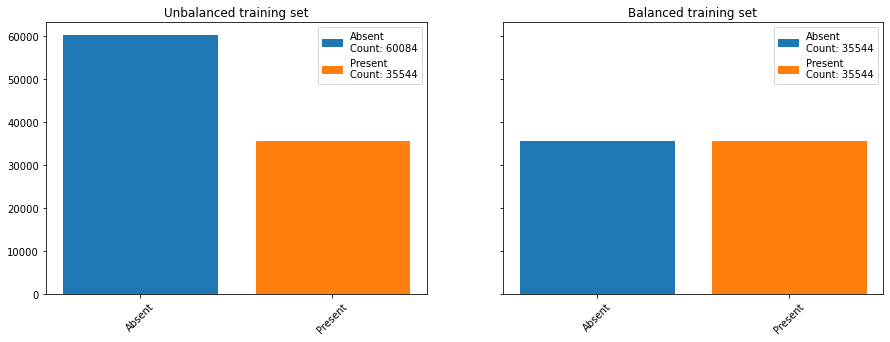

In [9]:
target_species_frog_data = all_frog_data[all_frog_data.occurrenceStatus == 1]
frog_data = (
    all_frog_data
    [lambda x: x.occurrenceStatus == 0]
    .sample(
        len(target_species_frog_data), random_state=420
    )
    .append(target_species_frog_data)
    # assign key for joining purposes
    .reset_index(drop=True)
    .assign(key=lambda x: x.index)
)
# Bar charts
fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharey=True, sharex=True)
bar_data = all_frog_data.occurrenceStatus.map({1:'Present', 0:'Absent'}).value_counts()
plot_barchart(bar_data, ax[0], bar_params={})
ax[0].set_title('Unbalanced training set')
balanced_bar_data = frog_data.occurrenceStatus.map({1:'Present', 0:'Absent'}).value_counts()
plot_barchart(balanced_bar_data, ax[1], bar_params={})
ax[1].set_title('Balanced training set')

The plot below show the class balanced

Text(0.5, 1.0, 'Training set for Greater Sydney, NSW')

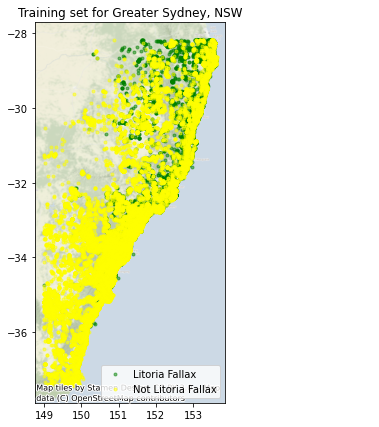

In [10]:
fig, ax = plt.subplots(figsize = (7, 7))

filt = frog_data.occurrenceStatus == 1
ax.scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude,
           color = 'green', marker='.', alpha=0.5, label=target_species)
ax.scatter(frog_data[~filt].decimalLongitude, frog_data[~filt].decimalLatitude,
           color = 'yellow', marker='.', alpha=0.5, label=f"Not {target_species}")
ax.legend()
cx.add_basemap(ax, crs={'init':'epsg:4326'}, alpha=0.5)
ax.set_title(f"Training set for {region_name}")

## Predictor Variables

Now that we have our response variable, it is time to gather the predictor variables from the TerraClimate dataset. For a more in-depth look at the TerraClimate dataset and how to query it, see the [TerraClimate supplementary notebook](./supplementary_notebooks/TerraClimate.ipynb)

### Accessing the TerraClimate Data

To get the TerraClimate data, we write a function called `get_terraclimate`. This function will fetch all data intersecting with the bounding box and will calculate various metrics over the time dimension for each coordinate. In this example, we will take four metrics from six assets, namely the mean maximum monthly air temp (`tmax_mean`), mean minimum monthly air temp (`tmin_mean`), mean accumulated precipitation (`ppt_mean`) and mean soil moisture (`soil_mean`), all calculated over a five year timeframe from the start of 2015 to the end of 2019.

Differently from the authors I will take 6 metrics: the mean maximum monthly air temp (`tmax_mean`), mean minimum monthly air temp (`tmin_mean`), mean accumulated precipitation (`ppt_mean`) and mean soil moisture (`soil_mean`),  mean water deficit (`def_mean`) and mean drought (`pdsi_mean`) all calculated over a fifty year timeframe from the start of 1970 to the end of 2020.

To assist in visualisations, this function has an interpolation functionality which will allow the comparitively coarse temporal resolution of the terraclimate data to be mapped to a larger set of coordinates, creating an ($n$ x $m$) image. We will choose (512 x 512).


In [11]:
def get_terraclimate(bbox, metrics, time_slice=None, assets=None, features=None, interp_dims=None, verbose=True):
    """Returns terraclimate metrics for a given area, allowing results to be interpolated onto a larger image.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    metrics -- Nested dictionary in the form {<metric_name>:{'fn':<metric_function>,'params':<metric_kwargs_dict>}, ... }
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    features -- list of asset metrics to take, specified by strings in the form '<asset_name>_<metric_name>'
    interp_dims -- Tuple of dimensions (n, m) to interpolate results to
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
    
    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    print('Loading data') if verbose else None
    data = data.rename(lat='y', lon='x').to_array().compute()
        
    # Calculate metrics
    combined_values = []
    combined_bands = []
    for name, metric in metrics.items():
        print(f'Calculating {name}') if verbose else None
        sum_data = xr.apply_ufunc(
            metric['fn'], data, input_core_dims=[["time"]], kwargs=metric['params'], dask = 'allowed', vectorize = True
        ).rename(variable='band')
        xcoords = sum_data.x
        ycoords = sum_data.y
        dims = sum_data.dims
        combined_values.append(sum_data.values)
        for band in sum_data.band.values:
            combined_bands.append(band+'_'+name)
        
    # Combine metrics
    combined_values = np.concatenate(
        combined_values,
        axis=0
    )
    combined_data = xr.DataArray(
        data=combined_values,
        dims=dims,
        coords=dict(
            band=combined_bands,
            y=ycoords,
            x=xcoords
        )
    )    

    # Take relevant bands:
    combined_data = combined_data.sel(band=features)
    
    if interp_dims is not None:
        print(f'Interpolating image') if verbose else None
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        combined_data = combined_data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
    
    return combined_data

Below, we define the products to take from TerraClimate in `assets` and the metrics to calculate from them in `tc_metrics`. Each metric is applied to each asset, so to pick the desired asset/metric pairs we define a list of strings in the form '\<asset\>_\<metric\>' in `features`. 

In [12]:
# Metrics to measure over time dimension
#TODO: Consider using also SD of the asset
tc_metrics = {
    'mean':{
        'fn':np.nanmean,
        'params':{}
    },
    'min':{
        'fn':np.nanmin,
        'params':{}
    },
    'max':{
        'fn':np.nanmax,
        'params':{}
    }
}

# Date range to take
time_slice = ('1970-01-01','2020-12-31')

# Measurements to take
assets=['tmax', 'tmin', 'ppt', 'soil', 'def', 'pdsi']

# Features to take, in form '<asset>_<metric>'
features=['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean', 'def_mean', 'pdsi_mean']

# Interpolate values to a 512x512 image
interp_dims = (512, 512)

weather_data = get_terraclimate(bbox, tc_metrics, time_slice=time_slice, assets=assets, features=features, interp_dims=interp_dims)
display(weather_data.band.values)

Loading data
Calculating mean
Calculating min
Calculating max
Interpolating image


array(['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean', 'def_mean',
       'pdsi_mean'], dtype='<U9')

### Visualising the TerraClimate Data
The spatial distribution of the four variables are displayed below.

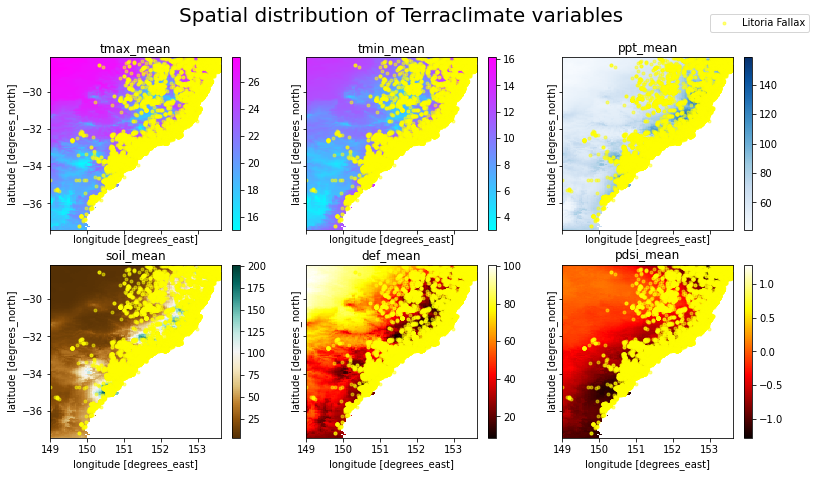

In [13]:
nrow = 2
ncol = 3
fig, ax = plt.subplots(nrow, ncol, figsize=(13, 7), sharex=True, sharey=True)

bands = weather_data.band.values
filt = frog_data.occurrenceStatus == 1
cmaps = ["cool", "cool", "Blues", "BrBG", "hot", "hot"]

for i in range(len(bands)):
    xr.plot.imshow(weather_data[i], 'x', 'y', cmap=cmaps[i], ax=ax[i//ncol, i%ncol]) 
    ax[i//ncol, i%ncol].set_title(bands[i])
    ax[i//ncol, i%ncol].scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude,
                                color = 'yellow', marker='.', alpha=0.5, label=target_species if i==0 else '')

fig.suptitle("Spatial distribution of Terraclimate variables", fontsize=20)
fig.legend(loc=(0.85, 0.933))

### Feature engineering
The frequency distribution of each variable is displayed below. There is some skewness present in a few variables, so we will address this when training your own model.

Text(0.5, 0.98, 'Frequency distribution of TerraClimate variables')

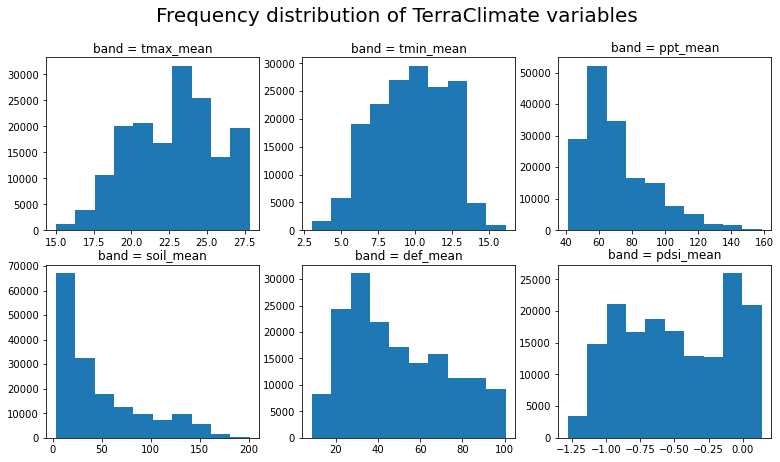

In [14]:
nrow = 2
ncol = 3
fig, ax = plt.subplots(nrow, ncol, figsize=(13, 7))

bands = weather_data.band.values

for i in range(len(bands)):
    xr.plot.hist(weather_data[i], ax=ax[i//ncol, i%ncol])

fig.suptitle("Frequency distribution of TerraClimate variables",  fontsize=20)

### Joining Pretictors to the Response Variable

Now that we have read in our predictor variables, we need to join them onto the response variable of frogs. To do this, we loop through the frog occurrence data and assign each frog occurrence the closest predictor pixel value from each of the predictor variables based on the geo-coordinates. The `sel` method of the xarray dataarray comes in handy here.

#### Join the data in the frogs df

In [15]:
def join_frogs(frogs, data):
    """Collects the data for each frog location and joins it onto the frog data 

    Arguments:
    frogs -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    data -- xarray dataarray of features, indexed with geocoordinates
    """
    return frogs.merge(
        (
            data
            .rename('data')
            .sel(
                x=xr.DataArray(frog_data.decimalLongitude, dims="key", coords={"key": frog_data.key}), 
                y=xr.DataArray(frog_data.decimalLatitude, dims="key", coords={"key": frog_data.key}),
                method="nearest"
            )
            .to_dataframe()
            .assign(val = lambda x: x.iloc[:, -1])
            [['val']]
            .reset_index()
            .drop_duplicates()
            .pivot(index="key", columns="band", values="val")
            .reset_index()
        ),
        on = ['key'],
        how = 'inner'
    )
    
model_data = join_frogs(frog_data, weather_data)
model_data.head()



,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus,key,def_mean,pdsi_mean,ppt_mean,soil_mean,tmax_mean,tmin_mean
0,3463684628,2020-05-26,Australia,Australia,New South Wales,-33.32450,151.365000,Crinia Signifera,0,0,24.813334,-0.985333,99.455002,87.003334,22.528502,12.195669
1,3108894816,2018-03-24,Australia,Australia,New South Wales,-32.08610,152.394000,Crinia Signifera,0,1,29.990000,-0.913333,91.050003,120.165001,23.887501,12.893335
2,3463500782,2020-06-05,Australia,Australia,New South Wales,-33.32440,151.365000,Crinia Signifera,0,2,24.813334,-0.985333,99.455002,87.003334,22.528502,12.195669
3,3463690350,2020-04-05,Australia,Australia,Australian Capital Territory,-35.16970,149.151000,Crinia Signifera,0,3,51.115002,-0.651000,54.478333,18.791666,20.018333,6.702502
4,3463708132,2020-09-16,Australia,Australia,New South Wales,-33.61851,151.082871,Crinia Signifera,0,4,30.001667,-0.970333,91.493332,67.853333,22.586836,11.744168


#### Cleaning the dataset
The function below cleans the dataset in case of Nan, Inf, -Inf. It then resets the index to prevent a jump in indexation which causes problem when doing cross-validation.

In [16]:
#The new dataframe has wrong indexes after dropping Nan, we have to reindex the df
model_data=model_data.dropna().reset_index(drop=True)

## Model Building

### Model Training

Now that we have the data in a format appropriate for machine learning, we can begin training a model. We will use [scikit-learn](https://scikit-learn.org/stable/) library, tensorflow and XGBoost.

Scikit-learn models require separation of predictor variables and the response variable. We store the predictor variables in dataframe `X` and the response in the array `y`. We must make sure to drop the response variable from `X`, otherwise the model will have the answers! It also doesn't make sense to use latitude and longitude as predictor variables in such a confined area, so we drop those too. Consider as a probable predictor the location, if it is near the sea we could have a much higher probability to find litoria fallax species.

### Feature scaling
In order to properly adress the problem arose before in the "feature engineering" section we might want to scale our predictors. In order to do that I will standardize all the predictors using the preprocessing module from scikit-learn.
It is quite a naive approach to standardize all our features, I will retain a copy of the initial vector `X` not scaled so that when I will train a random forest I can use my initial data as this model doesn't really require any feature scaling.

In [17]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
scaler = preprocessing.StandardScaler()

# Separate the predictor variables from the response
X_not_scaled = (
    model_data
    .drop(['gbifID', 'eventDate', 'decimalLatitude', 'decimalLongitude', 'species',
       'country', 'continent', 'stateProvince', 'occurrenceStatus', 'key'], 1)
)
y = model_data.occurrenceStatus.astype(int)

X = scaler.fit_transform(X_not_scaled) #applying scaling strips away column names as it transforms the pd.dataframe to a numpy.array

#Now we apply column names back to the scaled variables
X = pd.DataFrame(X, columns = X_not_scaled.columns)

## Model training
## 1)Logistic regression

In [18]:
lr_model = LogisticRegression()

# Fit model
lr_model.fit(X, y)

LogisticRegression()

### Model Prediction

#### Predict Training Set

Logistic regression is a machine learning model that estimates the probability of a binary response variable. In our case, the model will output the probability of a frog being present at a given location. To obtain the predictions for our training set, we simply use the `predict` method on our trained model. We will evaluate these predictions in the evaluation section of this notebook.

In [19]:
lr_pred = lr_model.predict(X)

#### Predict Entire Region

For a species distribution model to be effective, it must also be capable of performing predictions over the entire region, not just the points in our training set. To do this, we will define another function called `predict_frogs` that will take our interpolated predictor variable image in, along with our logistic regression model, and output the probabilities for each pixel in the region. We will visualise these predictions in a heatmap in the results section of this notebook.

This function will be used later to predict the test regions for the challenge. 

In [20]:
def predict_frogs(predictor_image, model):
    """Returns a (1, n, m) xarray where each pixel value corresponds to the probability of a frog occurrence.
    
    Takes in the multi-band image outputted by the `create_predictor_image` function as well as the
    trained model and returns the predictions for each pixel value. Firstly, the $x$ and $y$ indexes
    in the predictor image are stacked into one multi-index $z=(x, y)$ to produce an $k\times n$
    array, which is the format required to feed into our logistic regression model. Then, the array
    is fed into the model, returning the model's predictions for the frog likelihood at each pixel. 
    The predicted probabilities are then indexed by the same multi-index $z$ as before, which allows 
    the array to be unstacked and returned as a one-band image, ready for plotting.

    Arguments:
    predictor_image -- (K, n, m) xarray, where K is the number of predictor variables.
    model -- sklearn model with K predictor variables.
    """
    # Stack up pixels so they are in the appropriate format for the model
    predictor_image = predictor_image.stack(z=("y", "x")).transpose()
    # Reorder variables to be in same order as model
    predictor_image = predictor_image.sel(band=model.feature_names_in_)
    # Location of null values so that we can skip them (prediction model will break if nulls are present)
    null_pixels = (np.sum(predictor_image.isnull(), axis=-1) > 0)
    # Empty probabilities array
    probabilities = np.zeros((len(null_pixels), 2))
    # Calculate probability for each non-null pixel point
    probabilities[~null_pixels] = model.predict_proba(
        predictor_image[~null_pixels]
    )
    # Set null pixels to a probability of null
    probabilities[null_pixels] = np.array([np.nan, np.nan])
    # Just take probability of frog (class=1)
    probabilities = probabilities[:,1]
    # Add the coordinates to the probabilities, saving them in an xarray
    resultant_image = xr.DataArray(
        data=probabilities,
        dims=['z'],
        coords=dict(
            z=predictor_image.z
        )
    )
    # Unstack the image
    resultant_image = resultant_image.unstack()
    return resultant_image

# Calculate probability for each pixel point 
resultant_image = predict_frogs(weather_data, lr_model)

### Model Evaluation

Now that we have trained our model and made some predictions, all that is left is to evaluate it. We will do this by first visualising the output of the model with a probability heatmap. Then, we will evaluate both its in-sample and out-of-sample performance using the training set we have generated.

#### In-Sample Evaluation

In the last section, we made our predicitons for the training set and stored them in the `lr_pred` variable. We can now calculate some performance metrics to guage the effectiveness of the model. It must be stressed that this is the in-sample performance - the performance on the training set. Hence, the values will tend to overestimate its performance. Additionally, the training set itself is biased and this notebook only took naive approaches to address this. The model evaluation metrics are only as good as the data used to evaluate it, so the metrics themselves will also be biased. Thus, these metrics are NOT truly indicative of this model's performance. 

In this example, we will use `f1_score` and `accuracy_score` from Scikit-learn. Scikit-learn provides many other metrics that can be used for evaluation.

In [21]:
print(f"F1 Score: {np.mean(f1_score(y, lr_pred)).round(4)}")
print(f"Accuracy: {np.mean(accuracy_score(y, lr_pred)).round(4)}")

F1 Score: 0.7183
Accuracy: 0.6796


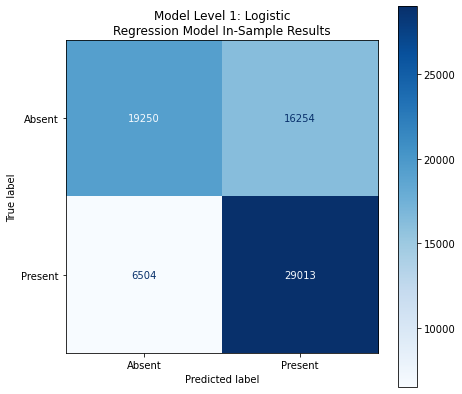

In [22]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(lr_model, X, y, display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Model Level 1: Logistic\nRegression Model In-Sample Results')
plt.show()

From above, we see that the model is able to achieve an ok F1 score and accuracy. From the confusion matrix, we can see that our model seems to confuse absent points with present points aka false positives, as shown in the top right corner. There may be many reasons for this, and a great way of understanding what might be causing the model's high false positive rate is to visualise its performance over the training region. We do this by plotting a probabilty heatmap in the section below.

#### Probability Heatmap

To create the probability heatmap, we write a function called `plot_heatmap`. This function will take in the model predictions from the entire region as stored in the `resultant_image` variable, and visualise these probabilities as a heatmap. In addition to the heatmap, we will also plot the actual map of the area in question, and the binary classification regions of the probability heatmap. The latter is simply a binary mask of the probability heatmap, 1 where the probability is greater than 0.5 and 0 elsewhere. 

To help visualise the effectiveness of our model, we plot the target species occurrences over top of each image. This can give us an idea of where our model is doing well, and where it is doing poorly. Particularly, we are interested in the high false positive rate.

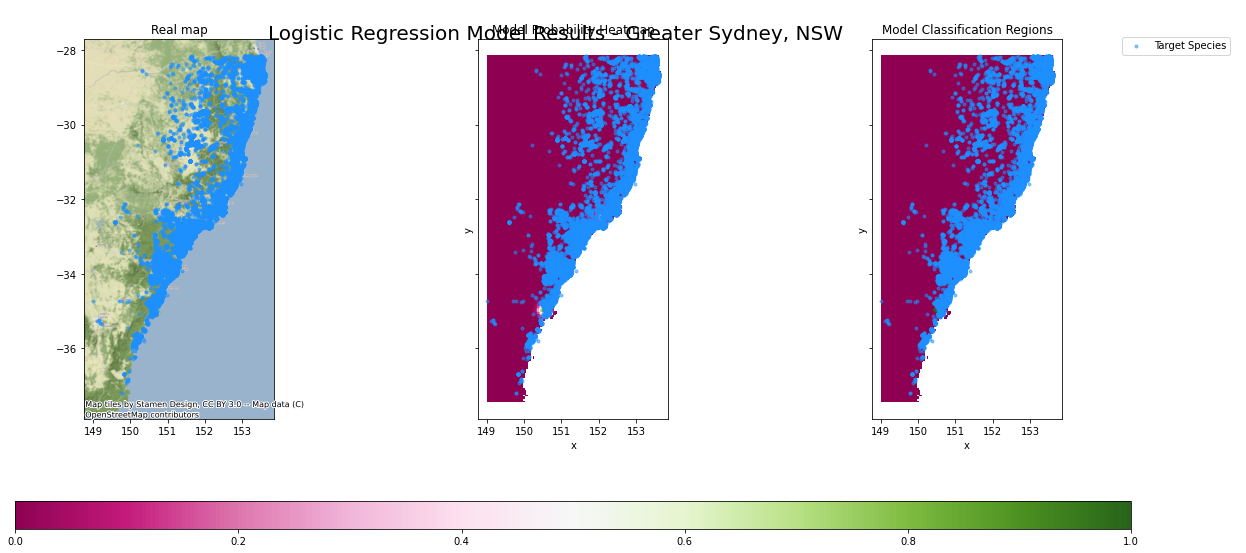

In [23]:
def plot_heatmap(resultant_image, frog_data, title, crs = {'init':'epsg:4326'}):
    """Plots a real map, probability heatmap, and model classification regions for the probability image from our model.

    Arguments:
    resultant_image -- (1, n, m) xarray of probabilities output from the model
    frog_data -- Dataframe of frog occurrences, indicated with a 1 in the occurrenceStatus column. 
                 Must contain ["occurrenceStatus", "decimalLongitude", "decimalLatitude"]
    title -- string that will be displayed as the figure title
    crs -- coordinate reference system for plotting the real map. Defaults to EPSG:4326.
    """
    fig, ax = plt.subplots(1, 3, figsize = (20, 10), sharex=True, sharey=True)
    extent = [resultant_image.x.min(),resultant_image.x.max(),resultant_image.y.min(),resultant_image.y.max()]
    cmap = 'PiYG'

    # Plot real map
    ax[0].scatter(x=[extent[0], extent[1]], y=[extent[2], extent[3]], alpha=0)
    cx.add_basemap(ax[0], crs=crs)
    ax[0].set_title('Real map')
    
    # Plot heatmap from model
    heatmap = resultant_image.plot.imshow(
        x='x', y='y', ax=ax[1], cmap=cmap, vmin=0, vmax=1, interpolation='none', add_colorbar=False
    )
    ax[1].set_aspect('equal')
    ax[1].set_title('Model Probability Heatmap')

    # Plot binary classification from model
    regions = xr.where(resultant_image.isnull(), np.nan, resultant_image>0.5).plot.imshow(
            x='x', y='y', ax=ax[2], cmap=cmap, vmin=0, vmax=1, interpolation='none', add_colorbar=False
    )
    ax[2].set_aspect('equal')
    ax[2].set_title('Model Classification Regions')

    # Plot real frogs
    for i, axis in enumerate(ax):
        filt = frog_data.occurrenceStatus == 1
        axis.scatter(
            frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude, 
            color = 'dodgerblue', marker='.', alpha=0.5, label='Target Species' if i==0 else ''
        )

    fig.colorbar(heatmap, ax=ax, location = 'bottom', aspect=40)
    fig.legend(loc = (0.9, 0.9))
    fig.suptitle(title, x=0.5, y=0.9, fontsize=20)
    
plot_heatmap(resultant_image, frog_data, f"Logistic Regression Model Results - {region_name}")

From the plots above, we can see that the model does a pretty good job of mapping where litoria fallax is. However, our performance metrics before suggested otherwise. The main limitation of the evaluation metrics comes from the pseudo absence species, crinia signifera, sharing much of the same habitat as litoria fallax. This paired with the relatively coarse spatial resolution of TerraClimate makes distinguising close habitats difficult. This explains the high rate of false positives, as there are many frog absence points within the green classification region.

#### Out-of-Sample Evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalise. This is because models have a tendancy to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will use k-fold cross-validation. This technique involves splitting the training dataset into folds, in this case we will use 10. Each iteration, the model is trained on all but one of the folds, which is reserved for testing. This is repeated until all folds have been left out once. At the end of the process, we will have 10 metrics which can be averaged, giving a more reliable and valid measure of model performance. 

Scikit-learn has built-in functions that can assist in k-fold cross validation. In particular, we will use `StratifiedKFold` to split our data into folds, ensuring there is always a balanced number of frogs and non-frogs in each fold.

In [24]:
def cross_validation(X, y, cv_model_to_asses, n_folds):
    global results, score
    skf = StratifiedKFold(n_splits=n_folds, random_state=420, shuffle=True)
    metrics = {'F1': f1_score, 'Accuracy': accuracy_score}
    results = {'predicted':[], 'actual':[]}
    scores = {'F1': [], 'Accuracy': []}

    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        # Split the dataset
        print(f"Fold {i+1} of {n_folds}")
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit the model with the training set
        cv_model_to_asses.fit(X_train, y_train)

        predictions = cv_model_to_asses.predict(X_test)

        for metric, fn in metrics.items():
            scores[metric].append(fn(y_test, predictions))

        results['predicted'].extend(predictions)
        results['actual'].extend(list(y_test))

    print(f'\nMetrics averaged over {n_folds} trials:')
    for metric, result in scores.items():
        print(f"{metric}: {np.mean(result).round(4)}")

        
cv_model = LogisticRegression()
n_folds = 10
cross_validation(X, y, cv_model, n_folds)   

Fold 1 of 10
Fold 2 of 10
Fold 3 of 10
Fold 4 of 10
Fold 5 of 10
Fold 6 of 10
Fold 7 of 10
Fold 8 of 10
Fold 9 of 10
Fold 10 of 10

Metrics averaged over 10 trials:
F1: 0.7185
Accuracy: 0.6797


The results from the 10-fold cross validation are similar than the in-sample metrics. This is a good sign as it shows that we haven't overfit our model. We see similar behavour in the higher rate of false positives that we saw in the in-sample performance.

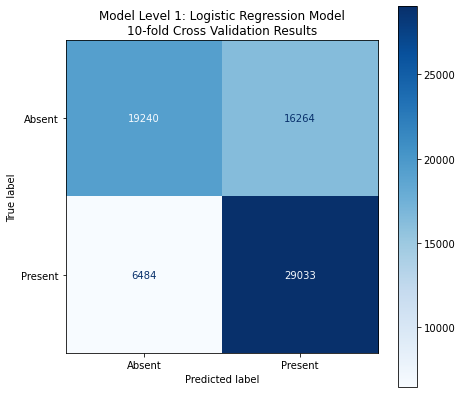

In [25]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(results['actual'], results['predicted'], display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Model Level 1: Logistic Regression Model\n10-fold Cross Validation Results')
plt.show()

## 2) Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier
randforest_model = RandomForestClassifier(oob_score=True)

# Fit model
randforest_model.fit(X, y)

#Prediction
rf_pred = randforest_model.predict(X)

# Calculate probability for each pixel point 
resultant_image = predict_frogs(weather_data, randforest_model)

#Score
print(f"F1 Score: {np.mean(f1_score(y, rf_pred)).round(4)}")
print(f"Accuracy: {np.mean(accuracy_score(y, rf_pred)).round(4)}")

F1 Score: 0.7887
Accuracy: 0.7817


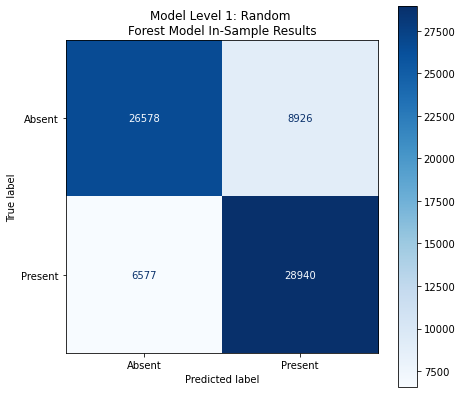

In [27]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(randforest_model, X, y, display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Model Level 1: Random \nForest Model In-Sample Results')
plt.show()

This model is much better in assessing false positives

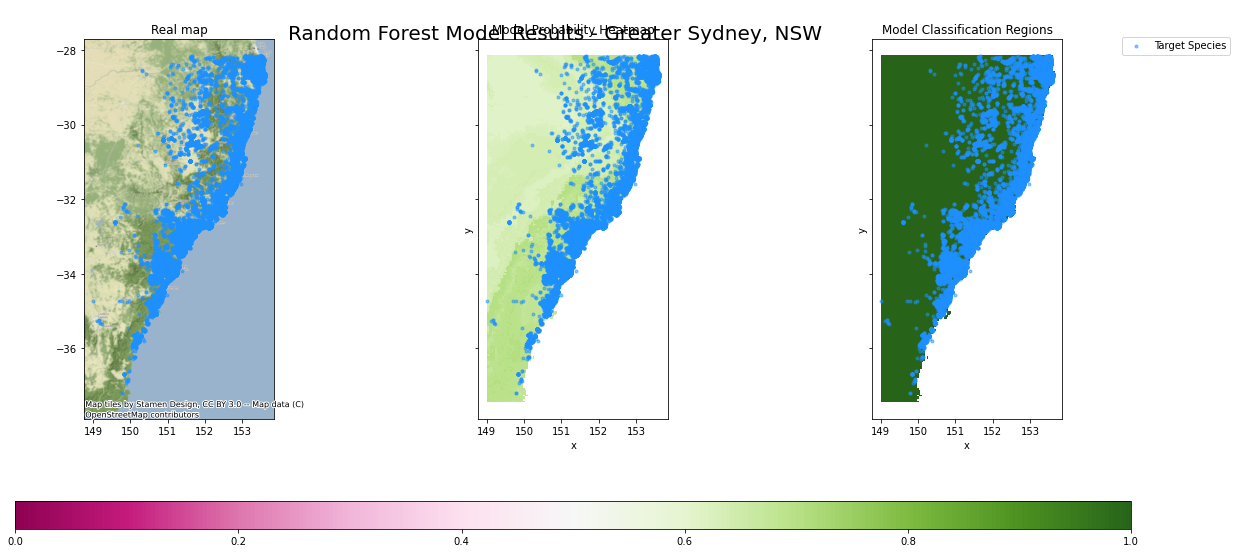

In [28]:
plot_heatmap(resultant_image, frog_data, f"Random Forest Model Results - {region_name}")

In [33]:
cv_model = RandomForestClassifier()
n_folds = 10
cross_validation(X, y, cv_model, n_folds) 

Fold 1 of 10
Fold 2 of 10
Fold 3 of 10
Fold 4 of 10
Fold 5 of 10
Fold 6 of 10
Fold 7 of 10
Fold 8 of 10
Fold 9 of 10
Fold 10 of 10

Metrics averaged over 10 trials:
F1: 0.7693
Accuracy: 0.7616


The results remain stable so that we are confident we are not overfitting. Moreover, this is a better result than the logistic regression

## 3) Bagging

Using bagging in order to select all features as potential candidate for splits and not only a subset as we use in random forests

In [29]:
from sklearn.ensemble import BaggingClassifier
bag_model = BaggingClassifier(oob_score=True)

# Fit model
bag_model.fit(X, y)

#Prediction
bag_pred = bag_model.predict(X)

# Calculate probability for each pixel point 
resultant_image = predict_frogs(weather_data, bag_model)

#Score
print(f"F1 Score: {np.mean(f1_score(y, bag_pred)).round(4)}")
print(f"Accuracy: {np.mean(accuracy_score(y, bag_pred)).round(4)}")

F1 Score: 0.7881
Accuracy: 0.7808


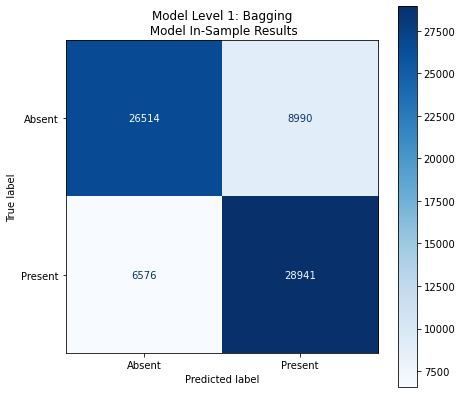

In [30]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(bag_model, X, y, display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Model Level 1: Bagging\n Model In-Sample Results')
plt.show()

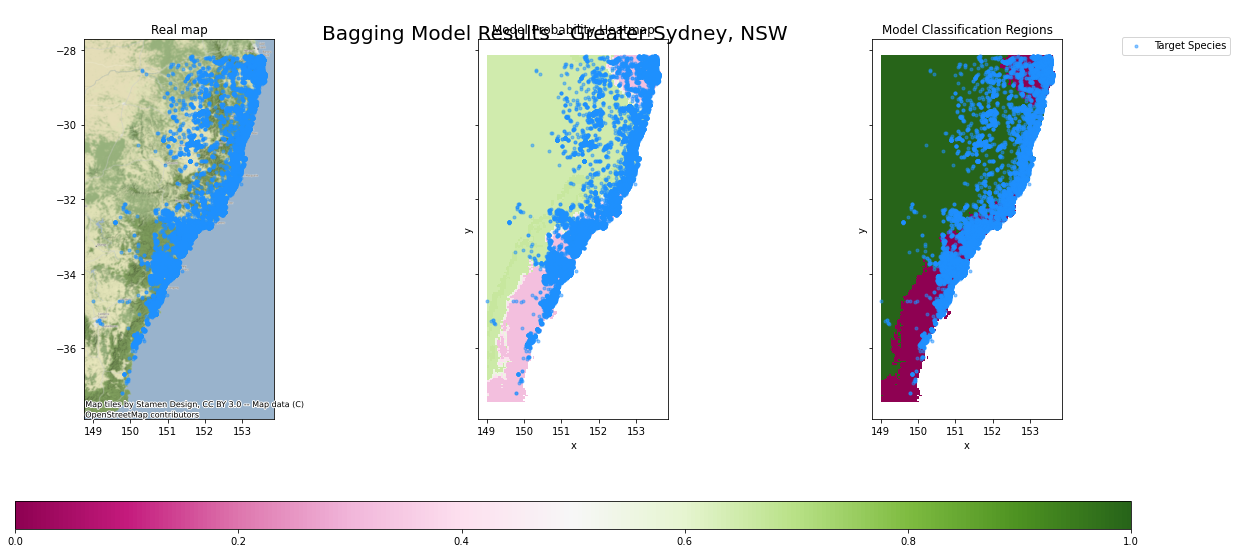

In [31]:
plot_heatmap(resultant_image, frog_data, f"Bagging Model Results - {region_name}")

In [32]:
cv_model = BaggingClassifier()
n_folds = 10
cross_validation(X, y, cv_model, n_folds) 

Fold 1 of 10
Fold 2 of 10
Fold 3 of 10
Fold 4 of 10
Fold 5 of 10
Fold 6 of 10
Fold 7 of 10
Fold 8 of 10
Fold 9 of 10
Fold 10 of 10

Metrics averaged over 10 trials:
F1: 0.7693
Accuracy: 0.7609


Results are very similar to that of the Random Forest model

## 4) Kernel SVM 

I will apply Grid Search in order to tune the best SVM. Takes a bit, do not run for now

In [33]:
from sklearn.svm import SVC
rbf_model = SVC(kernel = 'rbf', random_state = 0)

#Fit model
rbf_model.fit(X, y)

#Prediction
rbf_pred = rbf_model.predict(X)

# Calculate probability for each pixel point 
#resultant_image = predict_frogs(weather_data, rbf_model)

#Score
print(f"F1 Score: {np.mean(f1_score(y, rbf_pred)).round(4)}")
print(f"Accuracy: {np.mean(accuracy_score(y, rbf_pred)).round(4)}")

F1 Score: 0.7539
Accuracy: 0.732


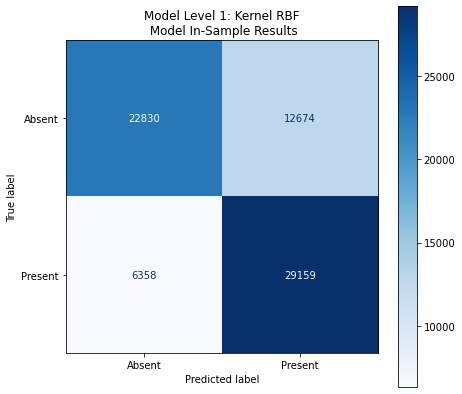

In [34]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(rbf_model, X, y, display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Model Level 1: Kernel RBF\n Model In-Sample Results')
plt.show()

In [ ]:
#from sklearn.model_selection import GridSearchCV
#parameters = [
#              {'C': [0.25, 0.5, 0.75, 1], 'kernel': ['rbf'], 'gamma': [0.1, 0.01, 0.001]}
#                           ]
#grid_search = GridSearchCV(estimator = classifier,
#                           param_grid = parameters,
#                           scoring = 'accuracy',
#                           cv = 10,
#                           n_jobs = -1)
#grid_search.fit(X, y)
#best_accuracy = grid_search.best_score_
#best_parameters = grid_search.best_params_
#print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
#print("Best Parameters:", best_parameters)

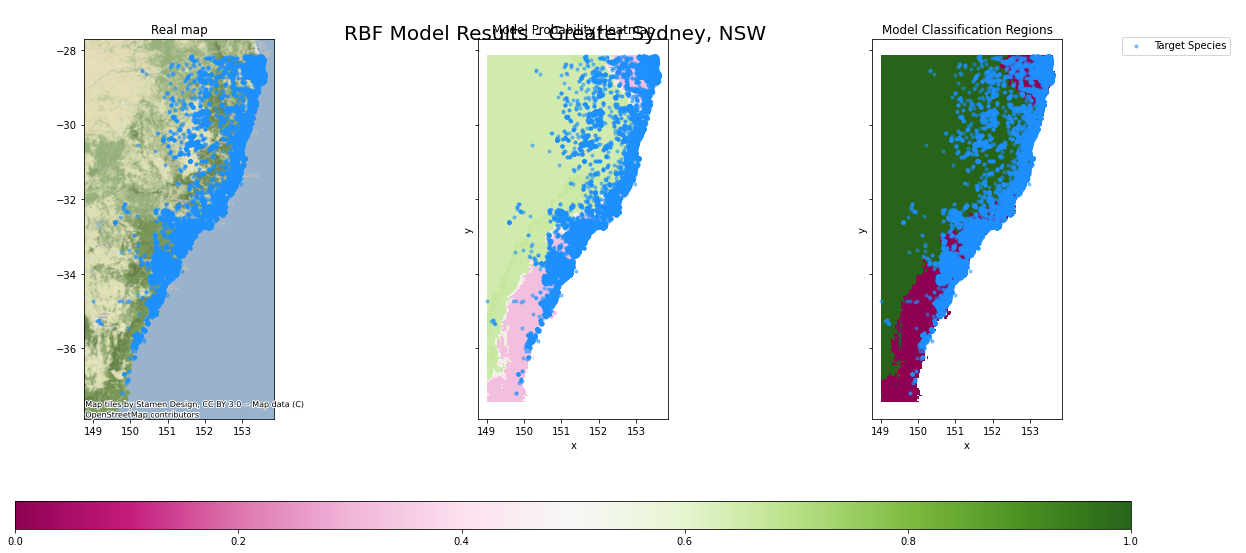

In [35]:
plot_heatmap(resultant_image, frog_data, f"RBF Model Results - {region_name}")

In [42]:
cv_model = SVC(kernel = 'rbf', random_state = 0)
n_folds = 10
cross_validation(X, y, cv_model, n_folds)

Fold 1 of 10
Fold 2 of 10
Fold 3 of 10
Fold 4 of 10
Fold 5 of 10
Fold 6 of 10
Fold 7 of 10
Fold 8 of 10
Fold 9 of 10
Fold 10 of 10

Metrics averaged over 10 trials:
F1: 0.7538
Accuracy: 0.7316


## 5) XGBoost

In [36]:
import xgboost
from xgboost import XGBClassifier

xgb_model = XGBClassifier(learning_rate=0.100000012, n_estimators=500)

#Model fit
xgb_model.fit(X, y)

#Prediction
xgb_pred = xgb_model.predict(X)

# Calculate probability for each pixel point 
#resultant_image = predict_frogs(weather_data, xgb_model)

#Score
print(f"F1 Score: {np.mean(f1_score(y, xgb_pred)).round(4)}")
print(f"Accuracy: {np.mean(accuracy_score(y, xgb_pred)).round(4)}")

[08:28:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 Score: 0.786
Accuracy: 0.7776


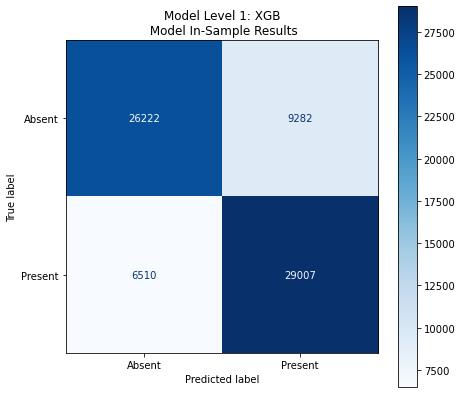

In [37]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(xgb_model, X, y, display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Model Level 1: XGB\n Model In-Sample Results')
plt.show()

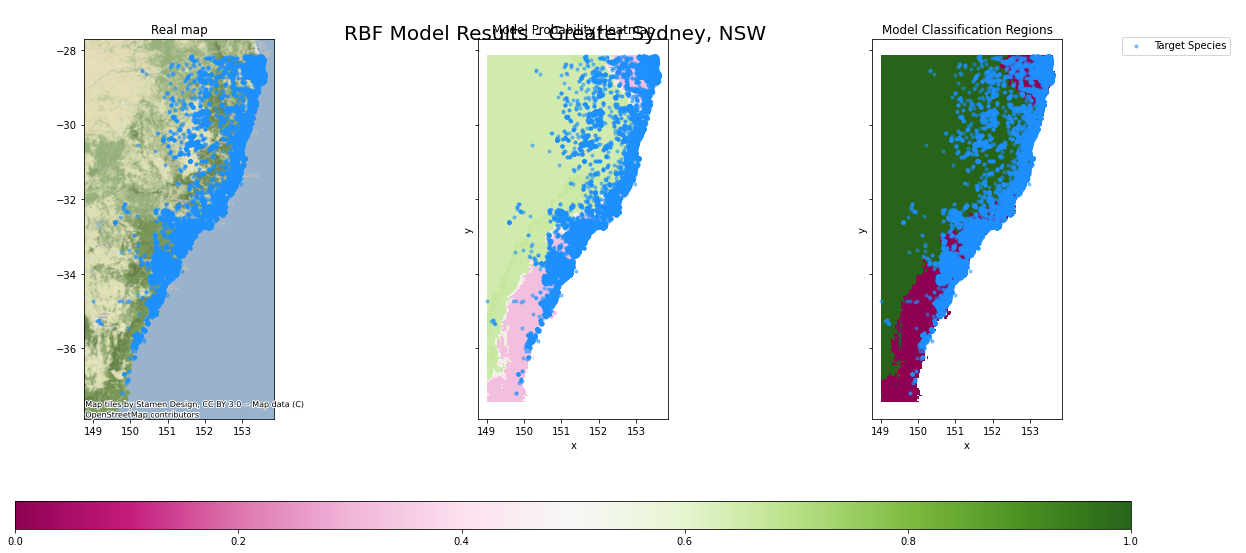

In [38]:
plot_heatmap(resultant_image, frog_data, f"RBF Model Results - {region_name}")

In [39]:
cv_model = XGBClassifier(learning_rate=0.100000012, n_estimators=500)
n_folds = 10
cross_validation(X, y, cv_model, n_folds)

Fold 1 of 10
[08:29:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold 2 of 10
[08:29:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold 3 of 10
[08:29:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold 4 of 10
[08:29:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly

## 6) Artificial Neural Network

In [40]:
import tensorflow as tf
#Initializing ANN
ann = tf.keras.models.Sequential()

#Add the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))

#Add the second hidden layer
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))

#Add the ouput layer
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

#Compile the ANN
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

#Fit the ANN to the data
ann.fit(X, y, batch_size = 32, epochs = 100) #Increasing the number of epochs does not seem to improve the accuracy

2022-05-02 08:31:32.873161: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-02 08:31:32.910542: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-02 08:31:32.931220: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-05-02 08:31:33.387802: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-02 08:31:33.508541: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2793435000 Hz


Epoch 1/100
2220/2220 [==============================] - 5s 1ms/step - loss: 0.6096 - accuracy: 0.6583
Epoch 2/100
2220/2220 [==============================] - 3s 1ms/step - loss: 0.5556 - accuracy: 0.7074
Epoch 3/100
2220/2220 [==============================] - 3s 1ms/step - loss: 0.5460 - accuracy: 0.7224
Epoch 4/100
2220/2220 [==============================] - 3s 1ms/step - loss: 0.5380 - accuracy: 0.7230
Epoch 5/100
2220/2220 [==============================] - 3s 1ms/step - loss: 0.5381 - accuracy: 0.7187
Epoch 6/100
2220/2220 [==============================] - 3s 1ms/step - loss: 0.5340 - accuracy: 0.7213
Epoch 7/100
2220/2220 [==============================] - 3s 1ms/step - loss: 0.5300 - accuracy: 0.7228
Epoch 8/100
2220/2220 [==============================] - 3s 1ms/step - loss: 0.5271 - accuracy: 0.7234
Epoch 9/100
2220/2220 [==============================] - 3s 1ms/step - loss: 0.5247 - accuracy: 0.7240
Epoch 10/100
2220/2220 [==============================] - 3s 1ms/step - l

In [68]:
#Predictions
pred_prob = ann.predict(X)

ann_pred = np.where(pred_prob > 0.5, 1,0)
print(ann_pred)

#Score
print(f"F1 Score: {np.mean(metrics.f1_score(y, ann_pred)).round(4)}")
print(f"Accuracy: {np.mean(metrics.accuracy_score(y, ann_pred)).round(4)}")

[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]
F1 Score: 0.7508
Accuracy: 0.7307


## ROC Curve for model comparison

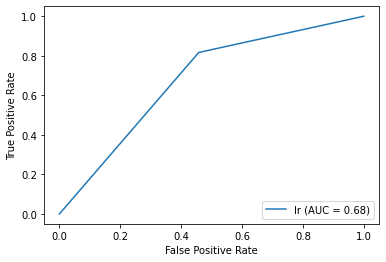

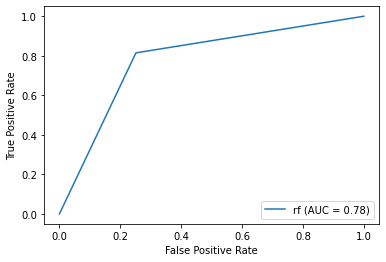

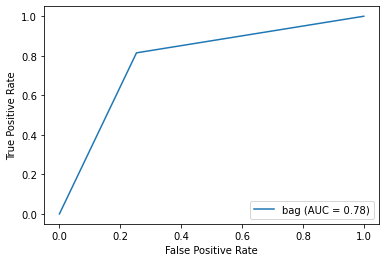

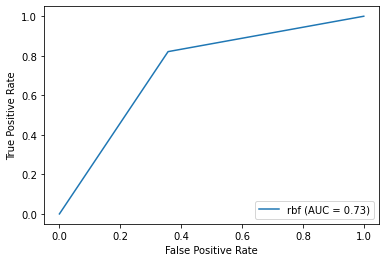

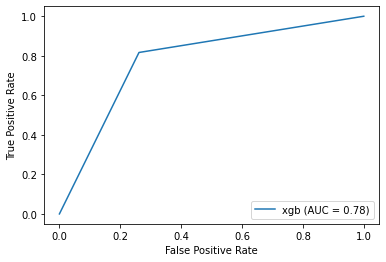

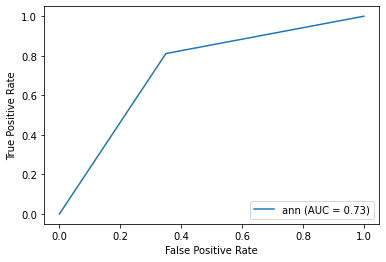

In [80]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
predictions = [lr_pred, rf_pred, bag_pred, rbf_pred, xgb_pred, ann_pred]
i=0
fpr=['','','','','','']  
tpr=['','','','','','']  
thresholds=['','','','','',''] 
roc_auc=['','','','','',''] 
display=['','','','','','']
estimator_name = ['lr', 'rf', 'bag', 'rbf','xgb', 'ann']
for a in range(len(predictions)):
    fpr[i], tpr[i], thresholds[i] = metrics.roc_curve(y, predictions[a])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    display[i] = metrics.RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i],
                                      estimator_name=estimator_name[i])
    display[i].plot()
    
    i=i+1
    

plt.show()

## Model Selection

We are comparing the different models in order to select the best one. At the end **we select the Random Forest classification** as it outperforms the other models.
See the df created

In [70]:
f1 = list([])
accuracy = list([])
predictions = [lr_pred, rf_pred, bag_pred, rbf_pred, xgb_pred, ann_pred]

for a in range(len(predictions)):
    f1.append(np.mean(metrics.f1_score(y, predictions[a])).round(4))
    accuracy.append(np.mean(metrics.accuracy_score(y, predictions[a])).round(4))
    
results = pd.DataFrame(data={'Models':['Logistic Regression', 'Random Forest', 'Bagging', 'Kernel RBF', 'XGBoost', 'Artificial Neural Network'],
                            'F1_Score':f1,
                            'Accuracy':accuracy,
                            'AUC': np.array(roc_auc).round(4)})

results.sort_values(by='F1_Score', ascending=False)


,Models,F1_Score,Accuracy,AUC
1,Random Forest,0.7887,0.7817,0.7817
2,Bagging,0.7881,0.7808,0.7808
4,XGBoost,0.7860,0.7776,0.7776
3,Kernel RBF,0.7539,0.7320,0.7320
5,Artificial Neural Network,0.7508,0.7307,0.7307
0,Logistic Regression,0.7183,0.6796,0.6795


## Submission

We select the model.... . We need to use the model to make predictions about the presence of litoria fallax for a set of test coordinates in the 'challenge_1_submission_template.csv' file. The list of bounding boxes where the points were sampled from can be found separately in the 'challenge_1_test_regions.txt' file. We loop through the regions identified in that file, pulling the TerraClimate data for that region, and extracting the features for each point in the 'test_1_occurrences.csv' file within that regions bounding box. This will minimise the computational requirements.

In [71]:
# Load in test coordinates
test_file = pd.read_csv('challenge_1_submission_template.csv')

In [72]:
# Read in test regions
test_1_regions = []
with open('challenge_1_test_regions.txt', 'r') as file: 
    for i, line in enumerate(file):
        if i > 0:
            test_1_regions.append(eval("("+line+")"))

In [73]:
# Load in regions and save as list of dictionaries.
test_regions = [{'title':i, 'bbox':bbox} for i, bbox in enumerate(test_1_regions)]

Loading data
Calculating mean
Calculating min
Calculating max


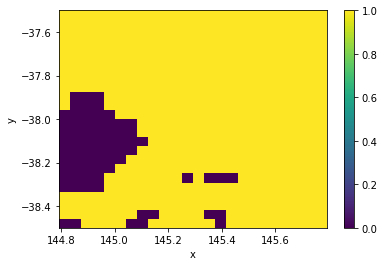

Loading data
Calculating mean
Calculating min
Calculating max


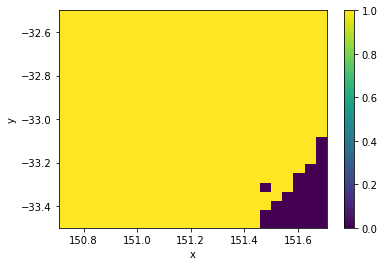

Loading data
Calculating mean
Calculating min
Calculating max


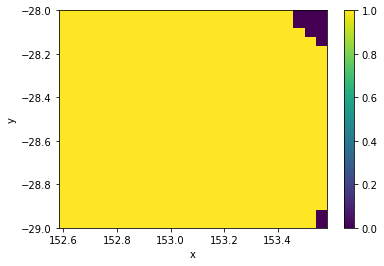

Loading data
Calculating mean
Calculating min
Calculating max


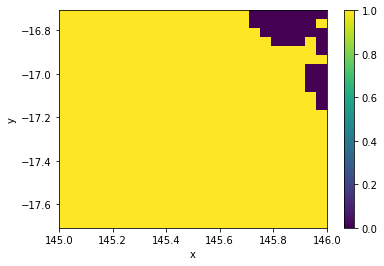

Loading data
Calculating mean
Calculating min
Calculating max


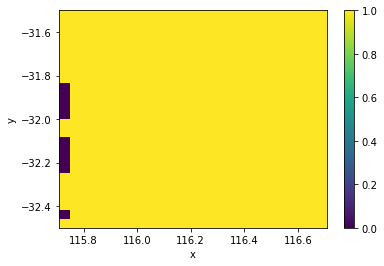

In [ ]:
# Obtain predictor data for each region and get predictor image
full_model = randforest_model
for region in test_regions:
    region['coords'] = filter_bbox(test_file[['id', 'decimalLongitude', 'decimalLatitude']], region['bbox'])
    region['predictors'] = get_terraclimate(region['bbox'], tc_metrics, time_slice=time_slice, assets=assets, features=features)
    region['result'] = predict_frogs(region['predictors'], full_model) > 0.5
    
    region['result'].plot.imshow(x='x', y='y', vmin=0, vmax=1)
    plt.show()
    

We can now use these classification regions to assign predictions for each of the coordinates specified in the test file. We do this in a similar way to the `join_frogs` function we defined earlier, except in this case we are joining a prediction to each coordinate.


In [81]:
predictions = pd.DataFrame()

for region in test_regions:
    preds = (
        region['result'].rename('occurrenceStatus')
        .sel(
            x=xr.DataArray(region['coords'].decimalLongitude, dims="id", coords={"id": region['coords'].id}), 
            y=xr.DataArray(region['coords'].decimalLatitude, dims="id", coords={"id": region['coords'].id}),
            method="nearest"
        )
        .to_dataframe()
        .reset_index()
        .rename(columns={'x':'decimalLongitude', 'y':'decimalLatitude'})
    )
    predictions = predictions.append(preds)
            
submission = (    
    predictions.merge(
        test_file, 
        on=['decimalLongitude', 'decimalLatitude'], 
        how='left', suffixes = ('', '_'))
    [test_file.columns]
    .fillna(0)
    .astype({col:'int' for col in test_file.columns[3::]})
)


What we are left with is a submission file with three columns: decimalLatitude, decimalLongitude, and occurrenceStatus. This is the file you will submit to the EY Data Science Challenge platform to receive your score on the leaderboard.

In [84]:
submission

# Save to output folder
submission.to_csv('challenge_1_submission_LV.csv', index=None)